# Korrelation & Zusammenhangsanalyse

In diesem Notebook analysieren wir die Zusammenhänge zwischen verschiedenen Variablen im Taxi-Datensatz. Wir untersuchen:
- Korrelationen zwischen numerischen Variablen
- Zusammenhänge zwischen Fahrtstrecke, Dauer und Kosten
- Zeitliche Muster und deren Einfluss auf andere Variablen

## 1. Daten laden und vorbereiten

In [2]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import random
import csv
import os

# Einstellungen für bessere Visualisierung
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Größere Plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [3]:
df = pd.read_csv('data/Taxi_final_1M.csv')

print(f"Datensatz geladen: {df.shape[0]:,} Zeilen, {df.shape[1]} Spalten")
print("\nErste Zeilen:")
df.head()

Datensatz geladen: 999,997 Zeilen, 17 Spalten

Erste Zeilen:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,27.4
1,2023-01-13 12:22:41,2023-01-13 12:54:42,1.0,0.0,76,61,1,22.0,0.0,0.00,0.0,1.0,23.50,0.0,0.0,32.0,0.0
2,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,18.1
3,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,24.9
4,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,24.9


### Datenbereinigung: Temporär. Richtige Bereinigung TODO in Notebook 4

In [4]:
# Datenbereinigung - Ausreisser entfernen für sinnvolle Analyse
# Nur realistische Werte behalten
df_clean = df[
    (df['trip_distance'] > 0) & (df['trip_distance'] < 100) &
    (df['trip_duration'] > 0) & (df['trip_duration'] < 180) &  # max 3 Stunden
    (df['fare_amount'] > 0) & (df['fare_amount'] < 200) &
    (df['total_amount'] > 0) & (df['total_amount'] < 250) &
    (df['passenger_count'] > 0) & (df['passenger_count'] <= 6) &
    (df['average_speed'] > 0) & (df['average_speed'] < 80)  # max 80 mph
].copy()

# Zeitvariablen berechnen
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['pickup_day_of_week'] = df_clean['pickup_datetime'].dt.dayofweek

print(f"Bereinigte Daten: {df_clean.shape[0]:,} Zeilen ({(df_clean.shape[0]/df.shape[0]*100):.1f}% der Originaldaten)")
print(f"\nDeskriptive Statistik:")
df_clean.describe()


Bereinigte Daten: 905,630 Zeilen (90.6% der Originaldaten)

Deskriptive Statistik:


,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_datetime,pickup_hour,pickup_day_of_week
count,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630.000000,905630,905630.000000,905630.000000
mean,1.392357,5.189776,165.886945,164.595815,1.196137,18.657574,1.599509,3.454588,0.503210,0.999689,27.581769,2.347755,0.123196,16.190726,28.002394,2023-07-02 06:40:26.932628480,14.339821,2.994508
min,1.000000,0.100000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,1.010000,0.000000,0.000000,0.100000,0.100000,2023-01-01 00:00:05,0.000000,0.000000
25%,1.000000,1.700000,132.000000,114.000000,1.000000,9.300000,0.000000,1.000000,0.000000,1.000000,15.960000,2.500000,0.000000,7.600000,18.500000,2023-04-02 09:07:57,11.000000,1.000000
50%,1.000000,2.800000,162.000000,162.000000,1.000000,13.500000,1.000000,2.860000,0.000000,1.000000,20.900000,2.500000,0.000000,12.400000,24.800000,2023-06-26 17:22:02,15.000000,3.000000
75%,1.000000,5.200000,234.000000,234.000000,1.000000,21.200000,2.500000,4.380000,0.000000,1.000000,29.750000,2.500000,0.000000,20.200000,33.700000,2023-10-06 09:43:28.249999872,19.000000,5.000000
max,6.000000,81.600000,265.000000,265.000000,4.000000,199.700000,14.250000,165.540000,85.000000,1.000000,249.660000,2.500000,1.750000,179.800000,79.900000,2023-12-31 23:59:59,23.000000,6.000000
std,0.884703,6.514506,63.842033,69.341614,0.449352,15.788445,1.802229,3.706454,1.937394,0.014940,20.216052,0.597858,0.435339,13.106039,14.028250,NaN,5.712669,1.920316


## 2. Korrelationsmatrix - Überblick über alle Zusammenhänge

Wir berechnen die Korrelation zwischen allen numerischen Variablen. Der Korrelationskoeffizient misst die Beziehung zwischen zwei Variablen und liegt zwischen -1 und +1:
- +1: Perfekte positive Korrelation
- 0: Keine lineare Korrelation
- -1: Perfekte negative Korrelation

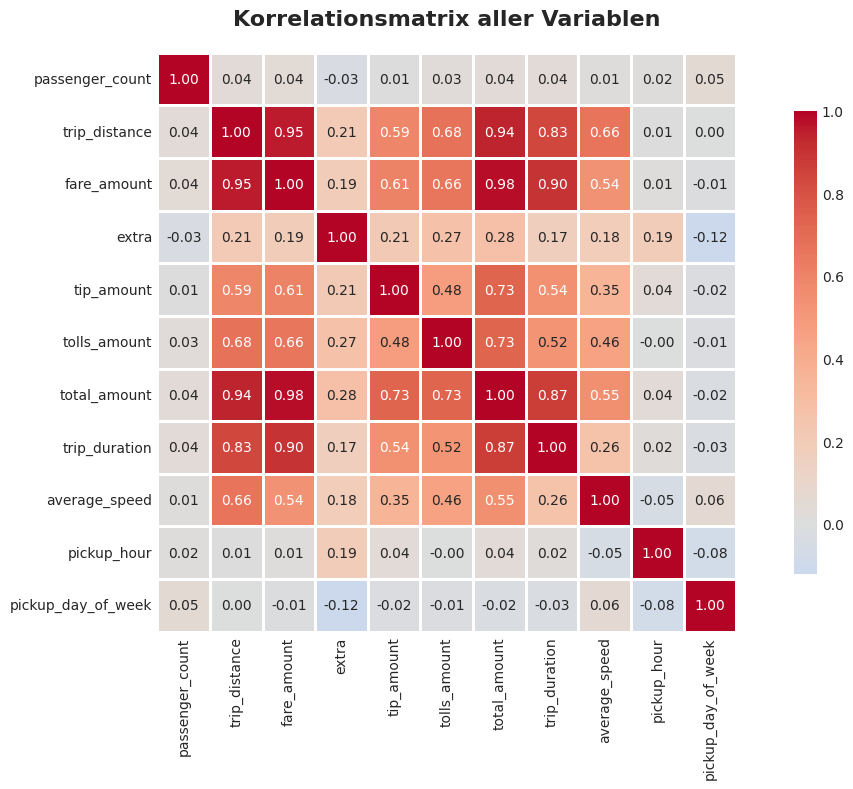

In [26]:
# Auswahl der numerischen Variablen
numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount', 
                  'extra', 'tip_amount', 'tolls_amount', 
                  'total_amount', 'trip_duration', 'average_speed',
                  'pickup_hour', 'pickup_day_of_week']

# Korrelationsmatrix
correlation_matrix = df_clean[numerical_cols].corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Korrelationsmatrix aller Variablen', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [6]:
# Die stärksten Korrelationen identifizieren (Diagonale auslassen)
# Korrelationsmatrix zu DataFrame 
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Diagonale entfernen

# Sortieren nach 
strong_correlations = corr_pairs.abs().sort_values(ascending=False).drop_duplicates()

print("Die stärksten Korrelationen:")
for idx, value in strong_correlations.head(15).items():
    print(f"{idx[0]:15s} <-> {idx[1]:15s}: {corr_pairs[idx]:7.3f}")

Die stärksten Korrelationen:
fare_amount     <-> total_amount   :   0.979
fare_amount     <-> trip_distance  :   0.953
total_amount    <-> trip_distance  :   0.941
fare_amount     <-> trip_duration  :   0.899
trip_duration   <-> total_amount   :   0.871
trip_duration   <-> trip_distance  :   0.835
tolls_amount    <-> total_amount   :   0.731
tip_amount      <-> total_amount   :   0.731
tolls_amount    <-> trip_distance  :   0.675
trip_distance   <-> average_speed  :   0.663
tolls_amount    <-> fare_amount    :   0.662
fare_amount     <-> tip_amount     :   0.609
tip_amount      <-> trip_distance  :   0.588
total_amount    <-> average_speed  :   0.548
trip_duration   <-> tip_amount     :   0.541


## 3. Detaillierte Analyse: Fahrstrecke und Fahrpreis

Eine der wichtigsten Zusammenhänge ist die Beziehung zwischen der Fahrstrecke (`trip_distance`) und dem Fahrpreis (`fare_amount`). Das soll fast 1:1 korrelieren.

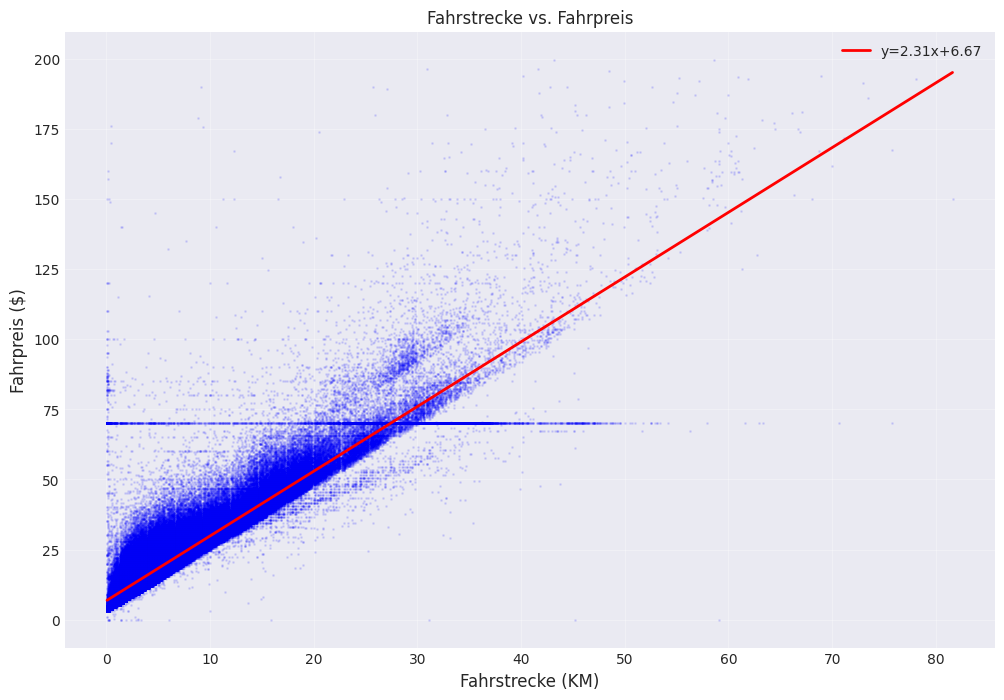

In [25]:
# Scatterplot: Fahrstrecke vs. Fahrpreis
plt.scatter(df_clean['trip_distance'], df_clean['fare_amount'], 
                alpha=0.1, s=1, c='blue')

# Regressionslinie hinzufügen
z = np.polyfit(df_clean['trip_distance'], df_clean['fare_amount'], 1)
p = np.poly1d(z)
plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('Fahrstrecke (KM)', fontsize=12)
plt.ylabel('Fahrpreis ($)', fontsize=12)
plt.title('Fahrstrecke vs. Fahrpreis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


Noch sind viele Ausreisser und wahrscheinliche Datenfehler zu sehen. Aber es gibt eine deutliche korrelation (und logischerweise Kausalität) zwischen Fahrpreis und Fahrtstrecke


## 4. Zusammenhang: Fahrstrecke und Fahrdauer

Untersuchen wir nun die Beziehung zwischen Fahrstrecke und Fahrdauer. Diese sollte auch positiv korrelieren, wobei die Durchschnittsgeschwindigkeit auch wichtig ist.

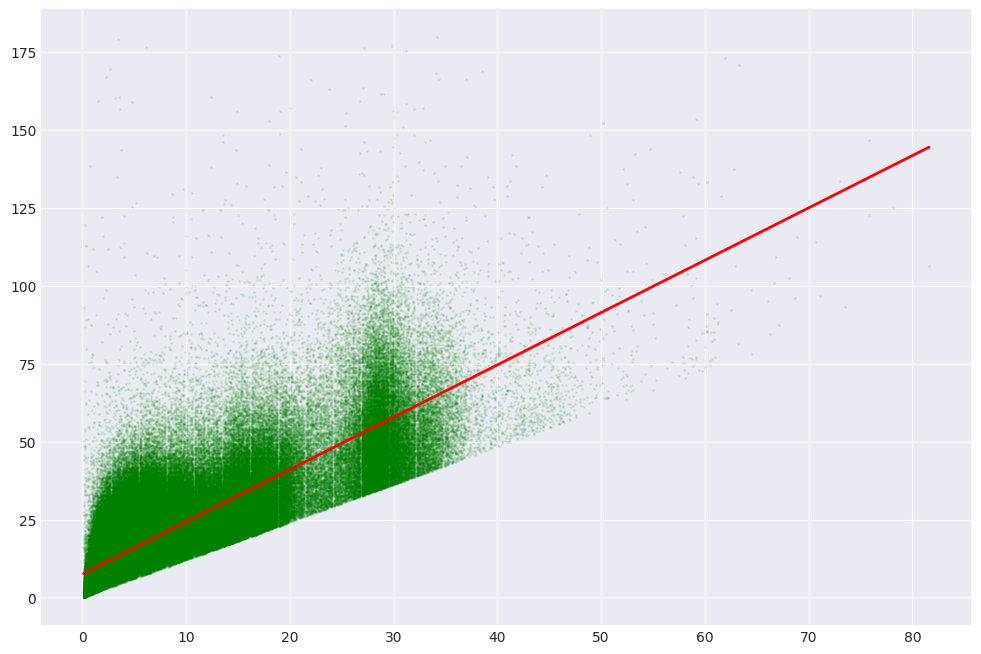


Durchschnittliche Geschwindigkeit aller Fahrten: 28.00 km/h


In [24]:
# Scatterplot: Fahrstrecke vs. Fahrdauer
plt.scatter(df_clean['trip_distance'], df_clean['trip_duration'], 
                alpha=0.1, s=1, c='green')

z = np.polyfit(df_clean['trip_distance'], df_clean['trip_duration'], 1)
p = np.poly1d(z)

plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2)
plt.show()

# Durchschnittliche Geschwindigkeit
avg_speed_overall = df_clean['average_speed'].mean()
print(f"\nDurchschnittliche Geschwindigkeit aller Fahrten: {avg_speed_overall:.2f} km/h")


## 5. Zusammenhang: Trinkgeld und Fahrpreis

Ein interessanter Zusammenhang ist die Beziehung zwischen dem Trinkgeld (`tip_amount`) und dem Fahrpreis (`fare_amount`). Wir erwarten ein höheres Trinkgeld bei höheren Fahrpreis, da es konvention ist prozentual Trinkgeld zu geben

/tmp/ipykernel_862/1229661017.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


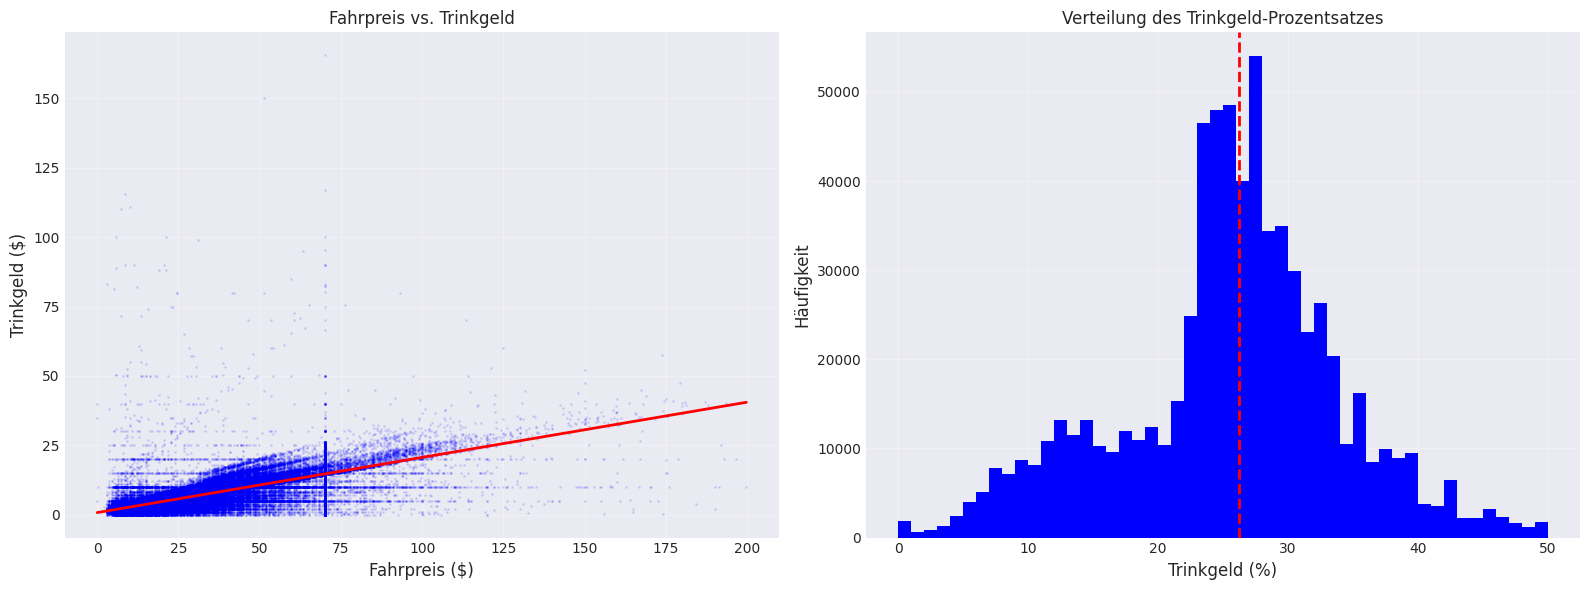

---Trinkgeld Statistiken---
Durchschnittlicher Prozentsatz Trinkgeld: 27.32%
Median Prozentsatz Trinkgeld: 26.25%
Fahrten mit Trinkgeld: 709,834 (78.4%)
Fahrten ohne Trinkgeld: 195,796 (21.6%)


In [23]:
# Trinkgeld-Prozentsatz berechnen
df_clean['tip_percentage'] = (df_clean['tip_amount'] / df_clean['fare_amount']) * 100

# Nur Fahrten mit Trinkgeld 
df_with_tip = df_clean[df_clean['tip_amount'] > 0].copy()
median_tip_perfentage = df_with_tip["tip_percentage"].median()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatterplot: Fahrpreis vs. Trinkgeld
axes[0].scatter(df_with_tip['fare_amount'], df_with_tip['tip_amount'], 
              alpha=0.1, s=1, color='blue')

z = np.polyfit(df_with_tip['fare_amount'], df_with_tip['tip_amount'], 1) # Schätzung Regressionsgrade
p = np.poly1d(z) # Polynom von z um zu plotten

axes[0].plot(df_with_tip['fare_amount'].sort_values(), 
          p(df_with_tip['fare_amount'].sort_values()), 
                "r-", linewidth=2)

axes[0].set_xlabel('Fahrpreis ($)', fontsize=12)
axes[0].set_ylabel('Trinkgeld ($)', fontsize=12)
axes[0].set_title('Fahrpreis vs. Trinkgeld')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trinkgeld-Prozentsatz Verteilung Histrogramm
df_with_tip[df_with_tip['tip_percentage'] <= 50]['tip_percentage'].hist(
    bins=50, ax=axes[1], color='blue')

axes[1].set_xlabel('Trinkgeld (%)', fontsize=12)
axes[1].set_ylabel('Häufigkeit', fontsize=12)
axes[1].set_title('Verteilung des Trinkgeld-Prozentsatzes')
axes[1].axvline(median_tip_perfentage, color='red', 
              linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("---Trinkgeld Statistiken---")
print(f"Durchschnittlicher Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].mean():.2f}%")
print(f"Median Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].median():.2f}%")
print(f"Fahrten mit Trinkgeld: {len(df_with_tip):,} ({len(df_with_tip)/len(df_clean)*100:.1f}%)")
print(f"Fahrten ohne Trinkgeld: {len(df_clean) - len(df_with_tip):,} ({(len(df_clean) - len(df_with_tip))/len(df_clean)*100:.1f}%)")

## TODO / Weitere Ideen
- Passagierzahl Zusammenhang mit verschiedenen Variablen
- Häufigsten Routen / Orte (Map zu LocationID's)
- Zahlungsmethode vs. Tip percentage
- Tageszeit vs. Tip/Distance/etc.